In [ ]:
# for modelling?
# why val loss lower than the val loss?
# why training loss is different after each run? --> need to control the inner seed in pytorch
# search for imbalanced classification?
# calculate the accuracy, matrix
# do CV under each epoch?


# for course report:
# delete unnecessay folder, write down readme
# add a mini training set for demo: can I only include code0?
# save params in json file?

In [4]:
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import random
import torch
import sys
import os
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import math
curr_path = os.getcwd()
print(curr_path)
sys.path.insert(0, os.path.dirname(curr_path))

import src.data.data_preprocess as preprocess
from src.models import bert
from src.data import data_preprocess

torch.random.manual_seed(42)


c:\Study_courses\2022_winter_LMU\Applied_DL_Bert\notebooks


In [5]:
len_all = 13478 # the length of the whole dataset
# len_all = 1000 # the length of the whole dataset

# split the data to (train & validation) and test sets
test_set_size = int(len_all * 0.15)
random.seed(1)
test_idx = random.sample(range(0, len_all), test_set_size)
train_val_idx = list(set(list(range(len_all))) - set(test_idx))

test_dataset = preprocess.seq_dataset(data_path=os.path.join(os.path.dirname(curr_path), 
                                            "data/imgt_I_domain_1_2.csv"), seqs_range = test_idx)

train_val_dataset = preprocess.seq_dataset(data_path=os.path.join(os.path.dirname(curr_path), 
                                            "data/imgt_I_domain_1_2.csv"), seqs_range = train_val_idx)


In [6]:
test_dataset[-100:]

('A', 'B', 'C', 'A', 'B', 'A', 'B', 'A', 'C', 'B', 'C', 'B', 'C', 'A', 'C', 'C', 'B', 'B', 'B', 'A', 'C', 'A', 'B', 'B', 'B', 'C', 'B', 'B', 'B', 'B', 'A', 'C', 'B', 'C', 'B', 'A', 'B', 'B', 'B', 'A', 'B', 'B', 'B', 'C', 'C', 'A', 'B', 'B', 'A', 'A', 'A', 'A', 'B', 'C', 'B', 'B', 'B', 'A', 'A', 'A', 'C', 'A', 'A', 'C', 'C', 'B', 'C', 'A', 'C', 'C', 'C', 'B', 'A', 'B', 'B', 'B', 'A', 'A', 'C', 'A', 'A', 'C', 'A', 'C', 'B', 'B', 'B', 'C', 'A', 'C', 'C', 'A', 'C', 'C', 'B', 'A', 'A', 'B', 'C', 'B')
('11', '57', '04', '02', '35', '03', '57', '03', '04', '44', '08', '51', '07', '01', '16', '16', '41', '07', '37', '25', '02', '24', '57', '15', '51', '04', '40', '46', '38', '55', '25', '07', '35', '07', '35', '30', '45', '07', '18', '24', '07', '57', '07', '07', '03', '03', '18', '15', '24', '80', '68', '68', '15', '07', '07', '57', '41', '01', '24', '23', '07', '33', '30', '16', '12', '52', '03', '30', '07', '15', '07', '73', '24', '55', '40', '35', '30', '03', '03', '02', '24', '05', '02', 

RuntimeError: Class values must be smaller than num_classes.

In [4]:
# model parameters
ebd_dim = 60 # Embedding Size
vocab_size = 24
max_seq_len = 182 # maximum sequence length is 181, but we add a [CLS] before it.
num_layer = 2 # number of Encoder of Encoder Layer
num_head = 2 # number of heads in Multi-Head Attention
dim_feedforward = ebd_dim * 4  # 4*ebd_dim, FeedForward dimension

# training parameters
lr=0.0002
num_epochs = 100
batch_size = 64
num_seqs = len(train_val_dataset)
num_iters = math.ceil(num_seqs/batch_size)
print(f'num_seqs: {num_seqs}, num_iters: {num_iters}')

verbose = True

num_seqs: 850, num_iters: 14


In [5]:
# 5-fold CV in pytorch
# https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-k-fold-cross-validation-with-pytorch.md
# https://stackoverflow.com/questions/63224426/how-can-i-cross-validate-by-pytorch-and-optuna

In [ ]:
train_loss_history = []
val_loss_history = []
min_val_loss = np.inf # to track the minimal validation loss

Bert_model = bert.Bert(ebd_dim=ebd_dim, num_head=num_head, vocab_size=vocab_size,
                        dim_feedforward=dim_feedforward,
                        num_layer=num_layer, max_seq_len=max_seq_len)

train_val_dataset = preprocess.seq_dataset(data_path=os.path.join(os.path.dirname(curr_path), 
                                            "data/imgt_I_domain_1_2.csv"), seqs_range = train_val_idx,
                                          seed=42)

train_size = int(0.8 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(train_val_dataset, 
                                            [train_size, val_size],
                                # generator=torch.Generator().manual_seed(42),
                                )
train_loader = DataLoader(dataset=train_dataset, 
                                        batch_size=batch_size, 
                                        shuffle=True)
val_loader = DataLoader(dataset=val_dataset, 
                                    batch_size=batch_size, 
                                    shuffle=True)

for epoch in range(num_epochs):
    train_loss = 0.0
    val_loss = 0.0
    
    Loss = nn.CrossEntropyLoss()
    # Loss_CE = nn.CrossEntropyLoss()
    # Loss_BCE = nn.CrossEntropyLoss()
    optimizer = optim.Adam(Bert_model.parameters(), lr=lr)
    
    # train_loader, is_train, optimizer, Bert_model, Loss
    for i, (token_data, mask_pos_data, mask_token_data, code0, code1, code2, padding_mask) in enumerate(train_loader):
        # remove the extra dimension
        token_data, mask_pos_data, mask_token_data, padding_mask, code0, code1, code2 = token_data.squeeze(1), \
        mask_pos_data.squeeze(1), mask_token_data.squeeze(1), padding_mask.squeeze(1),\
            code0.squeeze(1), code1.squeeze(1), code2.squeeze(1)

        # train the model
        optimizer.zero_grad()
        MaskedLM, code0_pred, code1_pred, code2_pred = Bert_model(input=token_data, padding_mask=padding_mask)
        # masked token prediction
        # (batch_size, n_mask) --> (batch_size,n_mask,vocab_size)
        masked_pos = mask_pos_data.unsqueeze(-1).expand(-1, -1, MaskedLM.size(-1))
        # (batch_size,source_len,vocab_size) --> (batch_size,n_mask,vocab_size)
        MaskedLM = torch.gather(MaskedLM, 1, masked_pos)
        # calculate the training loss       
        loss_maskLM = Loss(MaskedLM.transpose(1,2), mask_token_data)
        
        loss_code0 = Loss(code0_pred, code0.float())
        
        curr_loss = loss_maskLM + loss_code0
        
        curr_loss.backward()
        optimizer.step()
        train_loss += curr_loss.item()

        # # protein type prediction
        # if ((i+1) % 10 == 0) and verbose:
        #     print(f'Epoch: {epoch+1}/{num_epochs}, Step {i+1}/{num_iters}, training cost = {curr_loss.item():.5f}')
        
        
    epoch_train_loss = train_loss/len(train_loader)
    train_loss_history.append(epoch_train_loss)
    
    with torch.no_grad():
        for i, (token_data, mask_pos_data, mask_token_data, code0, code1, code2, padding_mask) in enumerate(val_loader):
            # remove the extra dimension
            token_data, mask_pos_data, mask_token_data, padding_mask, code0, code1, code2 = token_data.squeeze(1), \
            mask_pos_data.squeeze(1), mask_token_data.squeeze(1), padding_mask.squeeze(1),\
                code0.squeeze(1), code1.squeeze(1), code2.squeeze(1)

            MaskedLM, code0_pred, code1_pred, code2_pred = Bert_model(input=token_data, padding_mask=padding_mask)
            # masked token prediction
            # (batch_size, n_mask) --> (batch_size,n_mask,vocab_size)
            masked_pos = mask_pos_data.unsqueeze(-1).expand(-1, -1, MaskedLM.size(-1))
            # (batch_size,source_len,vocab_size) --> (batch_size,n_mask,vocab_size)
            MaskedLM = torch.gather(MaskedLM, 1, masked_pos)
            # calculate the training loss       
            loss_maskLM = Loss(MaskedLM.transpose(1,2), mask_token_data)
            loss_code0 = Loss(code0_pred, code0.float())
            curr_loss = loss_maskLM + loss_code0
            val_loss += curr_loss.item()
            
        epoch_val_loss = val_loss/len(val_loader)
        val_loss_history.append(epoch_val_loss)
        
        if verbose:
            print(f"Epoch {epoch+1}, training loss: {epoch_train_loss:.5f}, validation loss: {epoch_val_loss:.5f}")
        
        if epoch_val_loss < min_val_loss:
            if verbose:
                print(f'Validation loss decreased: ({min_val_loss:.5f}-->{epoch_val_loss:.5f}), saving the model.')
            min_val_loss = epoch_val_loss
            
            # save the model
            torch.save(Bert_model.state_dict(), 'saved_model.pth')

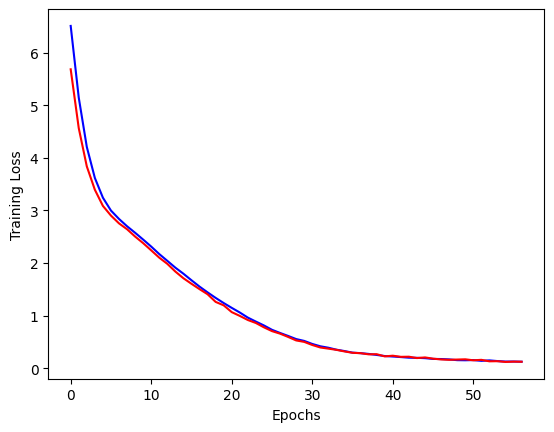

In [7]:
# plot the loss
plt.plot(train_loss_history, color="blue")
plt.plot(val_loss_history, color="red")
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.show()

In [ ]:
# https://www.geeksforgeeks.org/training-neural-networks-with-validation-using-pytorch/

In [ ]:
# loss_history = []
# Bert_model = bert.Bert(ebd_dim=ebd_dim, num_head=num_head, vocab_size=vocab_size,
#                         dim_feedforward=dim_feedforward,
#                                 num_layer=num_layer, max_seq_len=max_seq_len)


# for epoch in range(num_epochs):
#     dataset = preprocess.seq_dataset(data_path=os.path.join(os.path.dirname(curr_path), 
#                                             "data/imgt_I_domain_1_2.csv"), seqs_range = train_val_idx,
#                                           seed=epoch)
#     train_set_size = int(len(dataset) * 0.8)
#     val_set_size = len(dataset) - train_set_size
#     train_set, val_set = torch.utils.data.random_split(dataset, [train_set_size, val_set_size])
#     train_loader = DataLoader(dataset=train_set, 
#                                            batch_size=batch_size, 
#                                            shuffle=True)
#     Loss = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(Bert_model.parameters(), lr=lr)
    
#     for i, (token_data, mask_pos_data, mask_token_data, code0, code1, code2, pad_mask) in enumerate(train_loader):
        
#         # remove the extra dimension
#         token_data, mask_pos_data, mask_token_data, padding_mask = token_data.squeeze(1), \
#         mask_pos_data.squeeze(1), mask_token_data.squeeze(1), padding_mask.squeeze(1)
#         # train the model
#         optimizer.zero_grad()
#         NSP, MaskedLM = Bert_model(input=token_data, padding_mask=padding_mask)
        
#         # masked token prediction
#         # (batch_size, n_mask) --> (batch_size,n_mask,ebd_dim)
#         masked_pos = mask_pos_data.unsqueeze(-1).expand(-1, -1, MaskedLM.size(-1))
#         # (batch_size,source_len,ebd_dim) --> (batch_size,n_mask,ebd_dim)
#         MaskedLM = torch.gather(MaskedLM, 1, masked_pos)
        
#         # NSP predictions
        
        
#         # calculate the loss
#         loss_maskLM = Loss(MaskedLM.transpose(1,2), mask_token_data)
#         loss = (loss_maskLM.float()).mean()
        
#         # protein type prediction
        
        
#         # if (i+1) % 10 == 0:
#         print(f'Epoch: {epoch+1}/{num_epochs}, Step {i+1}/{num_iters}, cost = {loss}')
#         loss.backward()
#         optimizer.step()
#     # record loss in each epoch
#     loss_history.append(loss.item())
        
# # plot the loss
# plt.plot(loss_history)
# plt.xlabel("Epochs")
# plt.ylabel("Training Loss")
# plt.show()